In [56]:


def run_episode(env, policy, gamma, render = True):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

def evaluate_policy(env, policy, gamma , n = 100):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

def extract_policy(env,v, gamma):
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma):
    v = np.zeros(env.observation_space.n)
    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            break
    return v

def policy_iteration(env, gamma):
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  
    max_iters = 200000

    for i in range(max_iters):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(env,old_policy_v, gamma)

        if (np.all(policy == new_policy)):
            k=i+1
            break
        policy = new_policy
    return policy,k

def value_iteration(env, gamma):
    v = np.zeros(env.observation_space.n)  # initialize value-function
    max_iters = 100000
    eps = 1e-20

    for i in range(max_iters):
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            q_sa = [sum([p*(r + gamma*prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.action_space.n)] 
            v[s] = max(q_sa)

        if (np.sum(np.fabs(prev_v - v)) <= eps):
            k=i+1
            break
    return v,k

def plot_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')
            

    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.savefig(title+str('.png'))
    plt.show()

    return (plt)



def colors_lake():
    return {
        b'S': 'green',
        b'F': 'blue',
        b'H': 'brown',
        b'G': 'gold',
    }

def directions_lake():
    return {
        3: '∧',
        2: '>',
        1: '∨',
        0: '<'
    }







In [64]:
import mdptoolbox, mdptoolbox.example

In [2]:
import numpy as np
import gym
from gym import wrappers
import time
import sys
import matplotlib.pyplot as plt

In [3]:
data_collect = {}

In [62]:
P_name = 'ForestManagement'



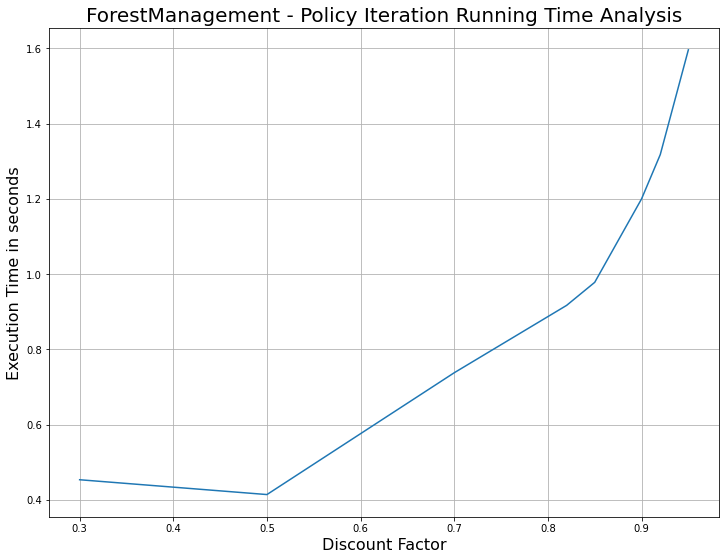

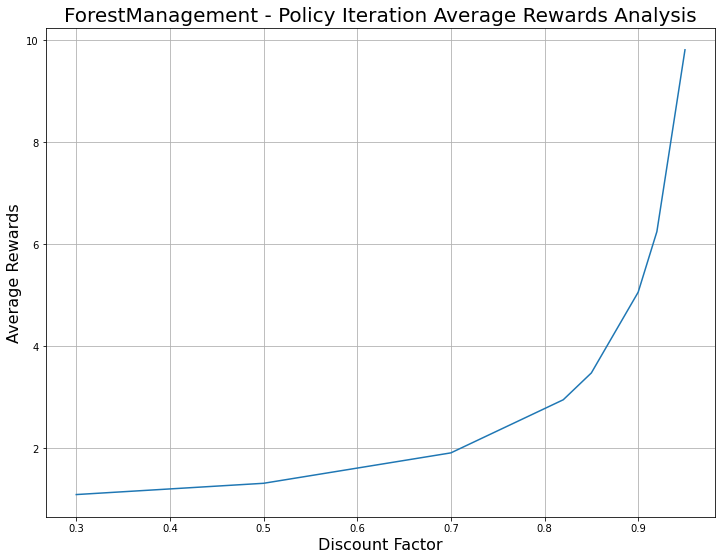

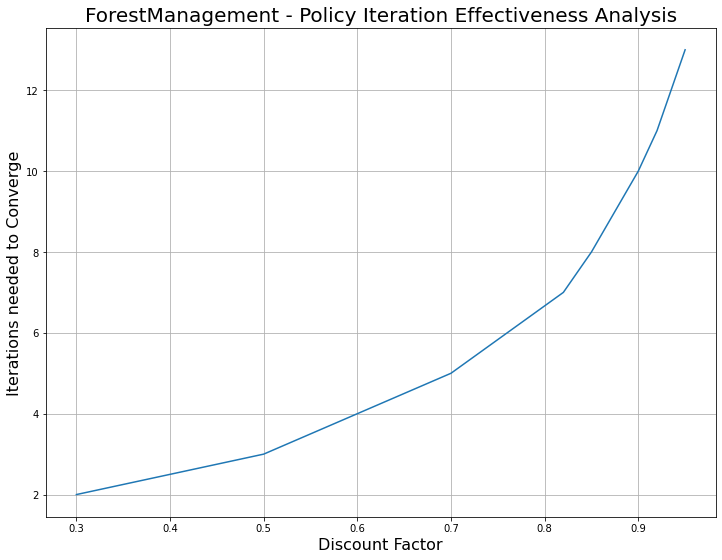

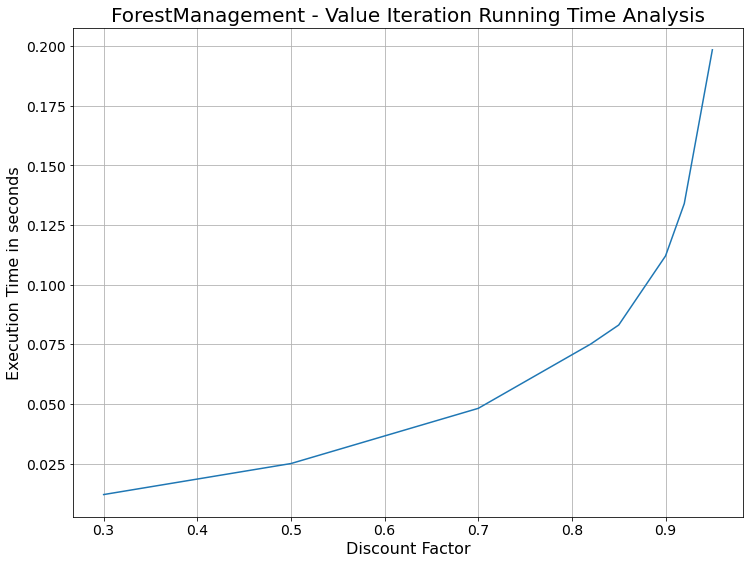

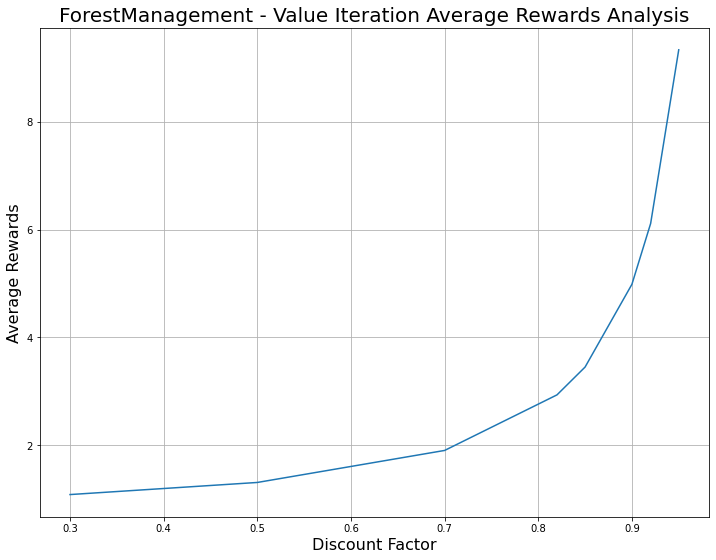

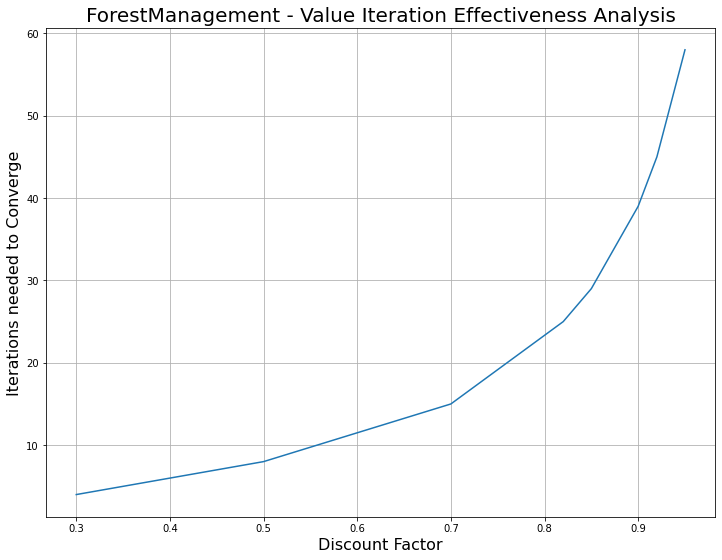

In [69]:

environment  = P_name

if P_name == 'FrozenLake-v1':
    env = gym.make(environment)
    desc = env.unwrapped.desc
    env = env.unwrapped
else:
    
    P, R = mdptoolbox.example.forest(S=2000)

# df_list=[.05,.1,.2,.3,.5,.7,.82,.85,.9,.92,.95] frozen lake
df_list=[.3,.5,.7,.82,.85,.9,.92,.95]


curr_data = {}
time_=[0]*len(df_list)
iters=[0]*len(df_list)
reward_list=[0]*len(df_list)
policy_list = [0]*len(df_list)
Cost_list = [0]*len(df_list)

if P_name == 'FrozenLake-v1':
    for i in range(len(df_list)):
    # print(i)
        st=time.time()
        best_policy,k = policy_iteration(env, gamma = df_list[i])
        rewards = evaluate_policy(env, best_policy, gamma = df_list[i])
        end=time.time()
        reward_list[i]=np.mean(rewards)
        iters[i] = k
        time_[i]=end-st
else:
    for i in range(len(df_list)):
        pi = mdptoolbox.mdp.PolicyIteration(P, R, df_list[i])
        pi.run()

        reward_list[i] = np.mean(pi.V)
        policy_list[i] = pi.policy
        iters[i] = pi.iter
        time_[i] = pi.time

fig, ax =  plt.subplots(figsize=(12,9))
plt.plot(df_list, time_)
plt.xlabel('Discount Factor', fontsize=16)
title = environment + ' - Policy Iteration Running Time Analysis'
plt.title(title, fontsize=20)
plt.ylabel('Execution Time in seconds', fontsize=16)
plt.grid()
plt.savefig(title+str('.png'))
# plt.show()

fig, ax =  plt.subplots(figsize=(12,9))
plt.plot(df_list,reward_list)
plt.xlabel('Discount Factor', fontsize=16)
plt.ylabel('Average Rewards', fontsize=16)
title = environment + ' - Policy Iteration Average Rewards Analysis'
plt.title(title, fontsize=20)
plt.grid()
plt.savefig(title+str('.png'))
# plt.show()

fig, ax =  plt.subplots(figsize=(12,9))
plt.plot(df_list,iters)
plt.xlabel('Discount Factor', fontsize=16)
plt.ylabel('Iterations needed to Converge', fontsize=16)
title = environment + ' - Policy Iteration Effectiveness Analysis'
plt.title(title, fontsize=20)
plt.grid()
plt.savefig(title+str('.png'))
# plt.show()

title = environment + ' - Policy Iteration Optimal Policy'
if P_name == 'FrozenLake-v1':
    plot = plot_policy_map(title,policy.reshape(4,4),desc,colors_lake(),directions_lake())
else:
    pass
curr_data['policy'] = [df_list,time_,reward_list,iters]


time_=[0]*len(df_list)

iters=[0]*len(df_list)
reward_list=[0]*len(df_list)


if P_name == 'FrozenLake-v1':
    for i in range(len(df_list)):
    #         print(i)
        st = time.time()
        best_value,k = value_iteration(env, gamma=df_list[i])
        policy = extract_policy(env, best_value, gamma=df_list[i])
        rewards = evaluate_policy(env, policy, gamma=df_list[i], n=1000)
        end = time.time()
        iters[i]=k
        time_[i]=end-st
        reward_list[i]=np.mean(rewards)
else:
    for i in range(len(df_list)):
        pi = mdptoolbox.mdp.ValueIteration(P, R, df_list[i])
        pi.run()

        reward_list[i] = np.mean(pi.V)
        policy_list[i] = pi.policy
        iters[i] = pi.iter
        time_[i] = pi.time    
fig, ax =  plt.subplots(figsize=(12,9))   
plt.plot(df_list, time_)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Discount Factor', fontsize=16)
title = environment + ' - Value Iteration Running Time Analysis'
plt.title(title, fontsize=20)
plt.ylabel('Execution Time in seconds', fontsize=16)
plt.grid()
plt.savefig(title+str('.png'))
# plt.show()

fig, ax =  plt.subplots(figsize=(12,9))
plt.plot(df_list,reward_list)
plt.xlabel('Discount Factor', fontsize=16)
plt.ylabel('Average Rewards', fontsize=16)
title = environment + ' - Value Iteration Average Rewards Analysis'
plt.title(title, fontsize=20)
plt.grid()
plt.savefig(title+str('.png'))
# plt.show()

fig, ax =  plt.subplots(figsize=(12,9))
plt.plot(df_list,iters)
plt.xlabel('Discount Factor', fontsize=16)
plt.ylabel('Iterations needed to Converge', fontsize=16)
title = environment + ' - Value Iteration Effectiveness Analysis'
plt.title(title, fontsize=20)
plt.grid()
plt.savefig(title+str('.png'))
# plt.show()



title = environment + ' - Value Iteration Optimal Policy'
if P_name == 'FrozenLake-v1':
    plot = plot_policy_map(title,policy.reshape(4,4),desc,colors_lake(),directions_lake())
else:
    pass
curr_data['value'] = [df_list,time_,reward_list,iters]




time_=[0]*len(df_list)

reward_list=[0]*len(df_list)
Q_list =[0]*len(df_list)

if P_name != 'FrozenLake-v1':
    for i in range(len(df_list)):
        st = time.time()
        pi = mdptoolbox.mdp.QLearning(P,R,df_list[i])
        end = time.time()
        pi.run()

        reward_list[i] = np.mean(pi.V)
        policy_list[i] = pi.policy
        time_[i] = end-st
        Q_list[i] = pi.Q
    fig, ax =  plt.subplots(figsize=(12,9))   
    plt.plot(df_list, time_)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('Discount Factor', fontsize=16)
    title = environment + ' - Q_learning Running Time Analysis'
    plt.title(title, fontsize=20)
    plt.ylabel('Execution Time in seconds', fontsize=16)
    plt.grid()
    plt.savefig(title+str('.png'))
    # plt.show()

    fig, ax =  plt.subplots(figsize=(12,9))
    plt.plot(df_list,reward_list)
    plt.xlabel('Discount Factor', fontsize=16)
    plt.ylabel('Average Rewards', fontsize=16)
    title = environment + ' - Q_learning Average Rewards Analysis'
    plt.title(title, fontsize=20)
    plt.grid()
    plt.savefig(title+str('.png'))
    # plt.show()

    fig, ax =  plt.subplots(figsize=(12,9))
    plt.plot(df_list,iters)
    plt.xlabel('Discount Factor', fontsize=16)
    plt.ylabel('Iterations needed to Converge', fontsize=16)
    title = environment + ' - Q_learning Effectiveness Analysis'
    plt.title(title, fontsize=20)
    plt.grid()
    plt.savefig(title+str('.png'))
    # plt.show()
data_collect[P_name] = curr_data

In [30]:
# Grid world
curr_data['QLearn'] = []
lr_list = [.6,.8,.9,.95,'flex']
df_list = [.6,.8,.9,.95]
for lr in lr_list:
    if lr == 'flex':
        change = True
        lr = 0
    else:
        change = False
    for df in df_list:
        environment  = P_name
        env = gym.make(environment)
        env = env.unwrapped
        desc = env.unwrapped.desc
        st=time.time()
        episodes = 10000
        epsilon=0
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        rewards = []
        iters = []
        optimal=[0]*env.observation_space.n
        for episode in range(episodes):
            state = env.reset()
            done = False
            t_reward = 0
            max_steps = 10000
            for i in range(max_steps):
                if done:
                    break
                current = state
                if np.random.rand()<epsilon:
                    action = np.argmax(Q[current, :])
                else:
                    action = env.action_space.sample()
                state, reward, done, info = env.step(action)
                t_reward += reward
                Q[current, action] += lr * (reward + df * np.max(Q[state, :]) - Q[current, action])
            epsilon=(1-2.71**(-episode/1000))
            if change:
                lr=2.71**(-episode/1000)

            rewards.append(t_reward)
            iters.append(i)
            
#         for k in range(env.observation_space.n):
#             optimal[k]=np.argmax(Q[k, :])
#             if np.argmax(Q[k, :])==5:
# #                 print(k)
#         #     print(optimal)
        print("learning rate:",lr)
        print("Discount factor:",df)
        print("average :",np.average(rewards[2000:]))
        env.close()
        end=time.time()
        if change:
            curr_data['QLearn'].append([{'df':df,'lr':'Decay','score':np.average(rewards[2000:]),'rwds':rewards,'itrs':iters,'time':end-st}])

        else:
            curr_data['QLearn'].append([{'df':df,'lr':lr,'score':np.average(rewards[2000:]),'rwds':rewards,'itrs':iters,'time':end-st}])


learning rate: 0.6
Discount factor: 0.6
average : 6.97725
learning rate: 0.6
Discount factor: 0.8
average : 6.983875
learning rate: 0.6
Discount factor: 0.9
average : 7.002875
learning rate: 0.6
Discount factor: 0.95
average : 7.02925
learning rate: 0.8
Discount factor: 0.6
average : 7.04275
learning rate: 0.8
Discount factor: 0.8
average : 7.042625
learning rate: 0.8
Discount factor: 0.9
average : 6.982375
learning rate: 0.8
Discount factor: 0.95
average : 6.960125
learning rate: 0.9
Discount factor: 0.6
average : 7.050125
learning rate: 0.9
Discount factor: 0.8
average : 7.02975
learning rate: 0.9
Discount factor: 0.9
average : 6.98125
learning rate: 0.9
Discount factor: 0.95
average : 7.01675
learning rate: 0.95
Discount factor: 0.6
average : 7.05225
learning rate: 0.95
Discount factor: 0.8
average : 7.046
learning rate: 0.95
Discount factor: 0.9
average : 6.983125
learning rate: 0.95
Discount factor: 0.95
average : 6.997125
learning rate: 4.685328659586058e-05
Discount factor: 0.6


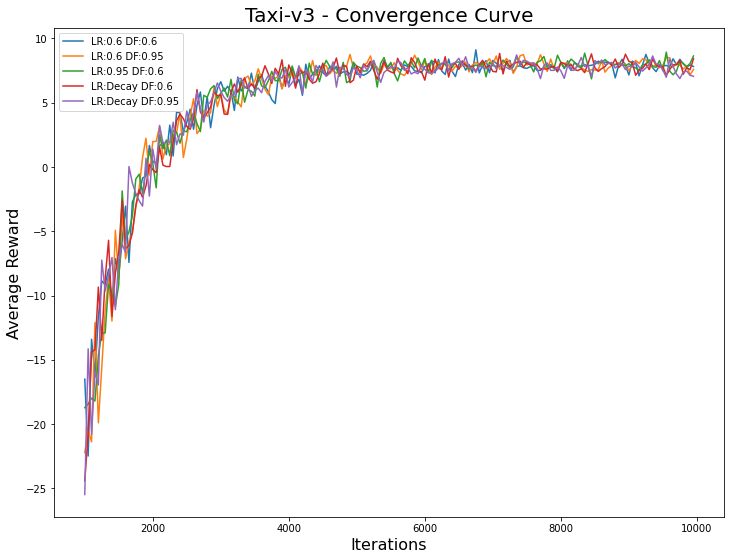

In [31]:
fig, ax =  plt.subplots(figsize=(12,9))

def chunk_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

size = 50
plot_list = [(0.6,0.6),(.95,.6),(.6,.95),('Decay',.6),('Decay',.95)]
for sim in range(len(curr_data['QLearn'])):
    if (curr_data['QLearn'][sim][0]['lr'] ,curr_data['QLearn'][sim][0]['df']) in plot_list:
        
        rewards = curr_data['QLearn'][sim][0]['rwds']
        chunks = list(chunk_list(rewards, size))
        averages = [sum(chunk) / len(chunk) for chunk in chunks]
        label = 'LR:'+ str(curr_data['QLearn'][sim][0]['lr']) + ' DF:' + str(curr_data['QLearn'][sim][0]['df'])
        plt.plot(range(0, len(rewards), size)[20:], averages[20:],label= label)
    
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Average Reward', fontsize=16)
title = environment + ' - Convergence Curve'
plt.title(title, fontsize=20)
plt.legend()
plt.savefig(title+str('.png'))
plt.show()
